## Click detection CNN model

In [62]:
# all libraries used in this notebook
import os.path
from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [6]:
# check if GPU is available, if not use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Import data and create the training, validation and test dataset

In [7]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [9]:
# import data from selected dataset

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets.sort(key=sort_key_func)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise']


In [19]:
dataset_num = 0

dataset_dir = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num])

# find files ending with .npz (stored numpy data) in the dataset_dir, if there is no such file in the direcori print there is noe npz file in the directory
file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]
if len(file_list) == 0:
    print("No npz file in the directory")
else:
    print(file_list)
    npz_file_num = 0

    file_fullpath = os.path.join(dataset_dir, file_list[npz_file_num])

    # check if the saved dataset can be loaded
    data = np.load(file_fullpath)
    loaded_spec_chunks = data['spec_chunks']
    loaded_spec_chunk_labels = data['labels']

    # check dataset information
    print(loaded_spec_chunks[0].shape)
    print(len(loaded_spec_chunks))
    print(len(loaded_spec_chunk_labels))
    # count the number of positive labels in numpy array
    print(np.count_nonzero(loaded_spec_chunk_labels == 1))

['spec_dataset_ethernet_wo_added_noise.npz']
(128, 32)
11144
11144
240


In [20]:
# normalize spectrogram chunks

## update with the decibel scale min max used in real time detection

def normalize_spectrogram_chunks(spec_chunks):
    # find global min and max values
    global_min = np.min(spec_chunks)
    global_max = np.max(spec_chunks)

    normalized_spectrograms = [(spec - global_min) / (global_max - global_min) for spec in spec_chunks]

    return normalized_spectrograms

spec_chunks_norm = normalize_spectrogram_chunks(loaded_spec_chunks)

print(spec_chunks_norm[0].shape)
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

(128, 32)
0.033793118 0.64435834


In [31]:
# split the dataset into training, validation and test sets

# create a dataframe to store the spectrogram chunks and their labels
df_spectrogram_dataset = pd.DataFrame(columns=['spectrogram', 'label'])

# add the spectrogram chunks and their labels to the dataframe
df_spectrogram_dataset['spectrogram'] = spec_chunks_norm
df_spectrogram_dataset['label'] = loaded_spec_chunk_labels

print(df_spectrogram_dataset.head())
print(df_spectrogram_dataset[df_spectrogram_dataset.label == 1].head())

# separate positive and negative samples in spec_chunks_norm dataset based on the labels in loaded_spec_chunk_labels
spec_chunks_OK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 1]
spec_chunks_NOK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 0]

# Function to split a dataframe according to the 60-20-20 ratio
def split_df(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)  # test_size = 0.2 --> 80% for training, 20% for validation and testing
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 10% for validation, 10% for testing
    return train, val, test

train_OK, val_OK, test_OK = split_df(spec_chunks_OK)
train_NOK, val_NOK, test_NOK = split_df(spec_chunks_NOK)

# Combine the corresponding sets
train_set = pd.concat([train_OK, train_NOK]).sample(frac=1, random_state=42) 
val_set = pd.concat([val_OK, val_NOK]).sample(frac=1, random_state=42)
test_set = pd.concat([test_OK, test_NOK]).sample(frac=1, random_state=42)

print(f"Train set size: {len(train_set)}, Validation set size: {len(val_set)}, Test set size: {len(test_set)}")
print(train_set.label.value_counts())
print(val_set.label.value_counts())
print(test_set.label.value_counts())
print(train_set[train_set.label == 1].head())

                                         spectrogram  label
0  [[0.033793118, 0.033793118, 0.033793118, 0.033...      0
1  [[0.033793118, 0.033793118, 0.033793118, 0.033...      0
2  [[0.033793118, 0.033793118, 0.033793118, 0.033...      0
3  [[0.033793118, 0.033793118, 0.033793118, 0.033...      0
4  [[0.033793118, 0.033793118, 0.033793118, 0.033...      0
                                           spectrogram  label
176  [[0.033793118, 0.033793118, 0.033793118, 0.033...      1
177  [[0.033793118, 0.033793118, 0.033793118, 0.033...      1
178  [[0.033793118, 0.033793118, 0.033793118, 0.033...      1
179  [[0.033793118, 0.033793118, 0.033793118, 0.033...      1
420  [[0.028709674, 0.028709674, 0.028709674, 0.028...      1
Train set size: 8915, Validation set size: 1114, Test set size: 1115
label
0    8723
1     192
Name: count, dtype: int64
label
0    1090
1      24
Name: count, dtype: int64
label
0    1091
1      24
Name: count, dtype: int64
                                           

In [50]:
# prepare data for model input

def prepare_data(df):
    X = np.stack(df['spectrogram'].values)  # convert spectrogram list to numpy array
    #X = np.expand_dims(X, axis=1)  # add channel dimension
    y = df['label'].values
    return X, y

X_train, y_train = prepare_data(train_set)
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

# convert to torch tensors
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X_train_tens, y_train_tens = to_tensor(X_train, y_train)
X_val_tens, y_val_tens = to_tensor(X_val, y_val)
X_test_tens, y_test_tens = to_tensor(X_test, y_test)

# View the first five samples
print(X_train_tens.shape, y_train_tens.shape)
print(X_val_tens.shape, y_val_tens.shape)
print(X_test_tens.shape, y_test_tens.shape)

train data shape: (8915, 128, 32)
train targets shape: (8915,)
val data shape: (1114, 128, 32)
val targets shape: (1114,)
test data shape: (1115, 128, 32)
test targets shape: (1115,) 

torch.Size([8915, 1, 128, 32]) torch.Size([8915])
torch.Size([1114, 1, 128, 32]) torch.Size([1114])
torch.Size([1115, 1, 128, 32]) torch.Size([1115])


In [51]:
# create dataloaders for training, validation and test sets

BATCH_SIZE = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
val_dataset = torch.utils.data.TensorDataset(X_val_tens, y_val_tens)
test_dataset = torch.utils.data.TensorDataset(X_test_tens, y_test_tens)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_loader)}")
print(f"Length of test dataloader: {len(val_loader)}")
print(f"Length of test dataloader: {len(test_loader)}")

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

Length of train dataloader: 558
Length of test dataloader: 70
Length of test dataloader: 70


(torch.Size([16, 1, 128, 32]), torch.Size([16]))

In [57]:
class ClickDetectorCNN(nn.Module):
    def __init__(self, input_channels, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, 
                      out_channels=64, 
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*64*8,
                      out_features=output_shape),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
model

ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [58]:
learning_rate = 0.001
epochs = 20

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

# early stopping parameters
patience = 3  # How many epochs to wait after last time validation loss improved.
delta = 0.001  # Minimum change in the validation loss to qualify as an improvement.
best_val_loss = float('inf')  # Initialize best validation loss as infinity
patience_counter = 0  # Counter for epochs since last improvement

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_loader):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)
        y_pred = torch.squeeze(y_pred)

        # 2. Calculate loss (per batch)
        loss = criterion(y_pred, y.float())
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in val_loader:
            val_pred = model(X)
            val_pred = torch.squeeze(val_pred)
            val_loss += criterion(val_pred, y.float()) # accumulatively add up the loss per epoch
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
    # Early Stopping Check
    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1  # Increment counter
        print(f"No improvement in validation loss for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

### Testing
# Setup variables for accumulatively adding up loss and accuracy 
test_loss, test_acc = 0, 0

all_preds = []
all_true_labels = []

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        # 1. Forward pass
        test_pred = model(X)
        test_pred = torch.squeeze(test_pred)
        
        # 2. Calculate loss (accumatively)
        test_loss += criterion(test_pred, y.float()) # accumulatively add up the loss per epoch

        # 3. Calculate accuracy (preds need to be same as y_true
        binary_predictions = (test_pred > 0.5).float()  # Convert to float for comparison

        # Calculate accuracy
        test_acc += (binary_predictions == y).float().mean().item()

        all_preds.extend(binary_predictions.tolist())
        all_true_labels.extend(y.tolist())
    
    # Calculations on test metrics need to happen inside torch.inference_mode()
    # Divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # Divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

## Print out what's happening
print(f"Test acc: {test_acc:.2f}%\n")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------


  5%|▌         | 1/20 [00:38<12:20, 38.97s/it]

Epoch: 1
-------


 10%|█         | 2/20 [01:15<11:16, 37.57s/it]

Epoch: 2
-------


 15%|█▌        | 3/20 [01:51<10:26, 36.88s/it]

Epoch: 3
-------


 20%|██        | 4/20 [02:27<09:46, 36.64s/it]

Epoch: 4
-------


 25%|██▌       | 5/20 [03:13<09:56, 39.79s/it]

No improvement in validation loss for 1 epochs.
Epoch: 5
-------


 30%|███       | 6/20 [03:56<09:31, 40.80s/it]

No improvement in validation loss for 2 epochs.
Epoch: 6
-------


 30%|███       | 6/20 [04:32<10:35, 45.39s/it]

No improvement in validation loss for 3 epochs.
Early stopping triggered.


Test acc: 1.00%



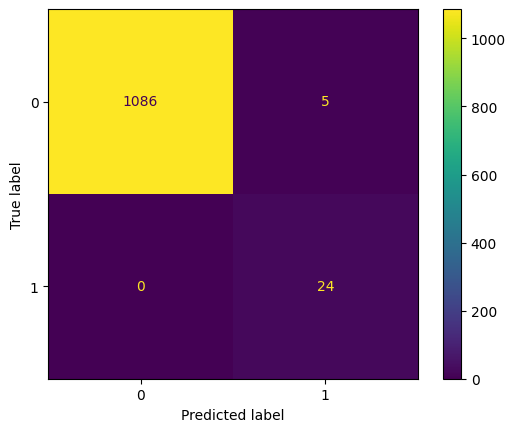

In [61]:
# plot out confusion matrix

cm = confusion_matrix(all_true_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

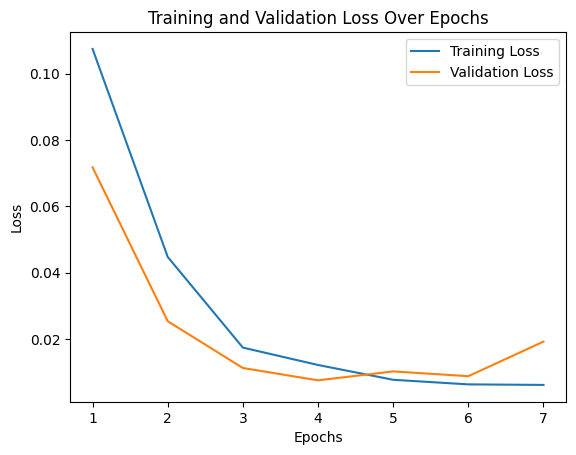

In [63]:
# print learning curves

train_loss_values = [loss.item() for loss in train_losses]
val_loss_values = [loss.item() for loss in val_losses]

epochs_range = range(1, len(train_loss_values) + 1)

plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()